# Raster Clipping

<br>

### Imports

In [73]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rasterio.plot import show
import rasterio as rio
import earthpy.spatial as es
from shapely.geometry import Polygon
import geopandas as gpd

from collections.abc import Iterable

<br>

### Reading in Data

<b>Elevation</b>

We start by reading in the elevation data

In [8]:
zambia_dem_filepath = 'data/cropped_elevation_WGS84_Zambia.tif'

zambia_dem = rio.open(zambia_dem_filepath) # Reading in digital elevation model

<br>

We can quickly visualise this

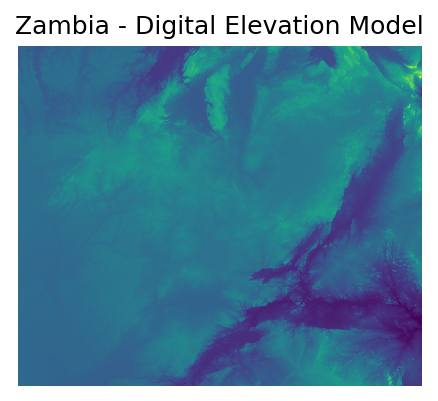

In [53]:
fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

show(zambia_dem, ax=ax)

ax.set_title('Zambia - Digital Elevation Model')
ax.set_axis_off()

<br>

<b>Country Border</b>

We now read in the country shapefile and extract the geometry

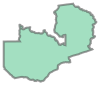

In [22]:
zambia_shp_filepath = 'data/Zambia.shp'

gdf_zambia = gpd.read_file(zambia_shp_filepath)

## Extracting the geometry
zambia_geom = gdf_zambia.loc[0, 'geometry']

zambia_geom

<br>

This can be overlayed on top of the elevation raster

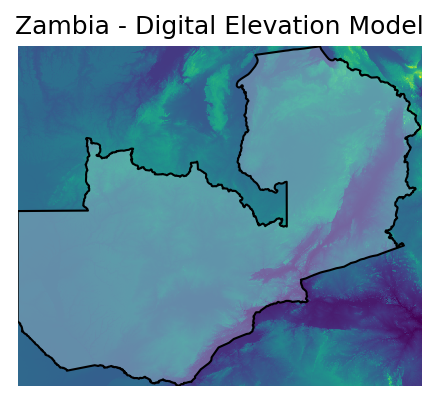

In [43]:
fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

show(zambia_dem, ax=ax)
gdf_zambia.plot(alpha=0.25, color='white', ax=ax) # We plot both the filled in polygon
ax.plot(*zambia_geom.exterior.xy, color='k', linewidth=1) # And add a darker border

ax.set_title('Zambia - Digital Elevation Model')
ax.set_axis_off()

<br>

### Cropping

Now to the actual problem at hand, we want to crop the data!

In [79]:
def cropper(raster, geoms, outpath):
    """
    This function accepts a raster object, an interable list of geometrys (or a single geometry),
    and a filepath to save the cropped raster to, the cropped raster is then read back in and returned.
    """    
    ## As crop accepts an iterable of geoms we first put any single geoms into a list
    if not isinstance(geoms, Iterable):
        geoms = [geoms]

    ## Next we crop the image
    raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

    ## We now need to update the metadata with the spatial data
    raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()}) # <- This is the 'mask' value
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
        
    raster_crop = rio.open(outpath)
    
    return raster_crop

zambia_dem_crop = cropper(zambia_dem, zambia_geom, 'data/cropped_dem_raster.tif')

<br>

We can now visualise the cropped raster

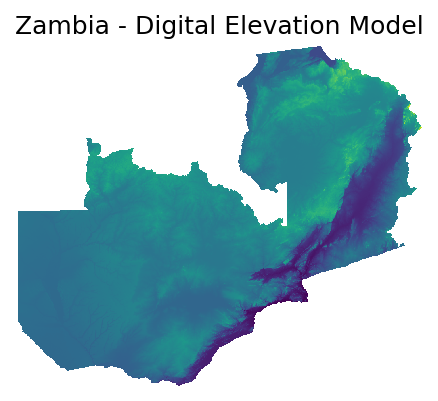

In [80]:
## Plotting
fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

show(zambia_dem_crop, ax=ax)

ax.set_title('Zambia - Digital Elevation Model')
ax.set_axis_off()